In [12]:
import numpy as np
import os
import subprocess
#import theano
import gzip

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import regularizers

import keras
from keras.models import Model
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate, Conv1D, BatchNormalization, Flatten
from keras.optimizers import Adagrad, Adam
from keras.utils import plot_model
from keras import regularizers

from keras.utils import plot_model
import matplotlib.pyplot as plt
import pickle
from keras.models import load_model

from sklearn.model_selection import train_test_split


In [1]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

import sys
!{sys.executable} -m pip install matplotlib

In [3]:
def get_split(X_train, X_valid, classSize, pssm = False):

    if not pssm:
        return (X_train[:,:,0:21], X_train[:,:,21 : (21+classSize)], 
                X_valid[:,:,0:21], X_valid[:,:,21 : (21+classSize)])
    else:
        return (X_train[:,:,21+classSize:], X_train[:,:,21 : (21+classSize)],
                X_valid[:,:,21+classSize:], X_valid[:,:,21 : (21+classSize)])

In [4]:
windowSize = 19 #19
predictionIndex = 9
classSize = 8  # 2 or 3 
numberOfFeatures = 50 #50 #44 #45


In [23]:
def get_dataset():
    
    f = gzip.GzipFile('X_train_window19Middle-repeating-left-right0.npy.gz', "r")
    X_train_window = np.load(f)
    
    f = gzip.GzipFile('X_valid_window19Middle-repeating-left-right0.npy.gz', "r")
    X_valid_window  = np.load(f)
    
    X_train_window = np.concatenate((X_train_window, X_valid_window), axis = 0)
    print(X_train_window.shape)
    
    
    X_train_window, X_valid_window = train_test_split(X_train_window, test_size=0.1)
    #x_train_final, y_train_final, x_valid_final, y_valid_final = get_split(X_train_window, X_valid_window, classSize, pssm = True)

    x_train_final = X_train_window[:,:,35:56]
    y_train_final = X_train_window[:,:,22:30]

    x_valid_final = X_valid_window[:,:,35:56]
    y_valid_final = X_valid_window[:,:,22:30]

    print(x_train_final.shape, "training data")
    print(y_train_final.shape, "labels for training data")
    print(x_valid_final.shape, "validation data")
    print(y_valid_final.shape, "labels for training validation")

    y_train_final = y_train_final[:,0,:]
    print(y_train_final.shape)

    y_valid_final = y_valid_final[:,0,:]
    print(y_valid_final.shape)
    
    return x_train_final,y_train_final,x_valid_final,y_valid_final

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf


nn_epochs = 15

   
LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
drop_out = 0.4
batch_dim = 64

loss = 'categorical_crossentropy'

input_shape = (windowSize, 21)

conv1_input = Input(shape=(windowSize, 21), name='InputWindow')
conv_1 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv1_input)
conv_1 = BatchNormalization(name='BN1')(conv_1)
#conv_1 = Dropout(drop_out)(conv_1)
conv_2 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_1)
conv_2 = BatchNormalization(name='BN2')(conv_2)
conv_2 = Dropout(drop_out)(conv_2)
conv_3 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_2)
conv_3 = BatchNormalization(name='BN3')(conv_3)
conv_3 = Dropout(drop_out)(conv_3)



conv_4 = Conv1D( 64, 3, strides=1, padding='same', activation='relu', use_bias=True)(conv_3)
conv_4 = BatchNormalization(name='BN4')(conv_4)
conv_4 = Dropout(drop_out)(conv_4)
conv_5 = Conv1D( 64, 3,  strides=1, padding='same', activation='relu', use_bias=True)(conv_4)
conv_5 = BatchNormalization(name='BN5')(conv_5)
conv_5 = Dropout(drop_out)(conv_5)
    #conv_6 = Conv1D( 73, 3, strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_5)
    #conv_6 = BatchNormalization(name='BN6')(conv_6)


    #conv_7 = Conv1D( 73, 3,  strides=1, padding='same', activation='relu', use_bias=True, kernel_regularizer=w_reg)(conv_6)
    #conv_7 = BatchNormalization(name='BN7')(conv_7)
    #conv_8 = Conv1D( 4, 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_7)
    #conv_8 = BatchNormalization(name='BN8')(conv_8)
    #conv_9 = Conv1D( 4, 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg)(conv_8)
    #conv_9 = BatchNormalization(name='BN9')(conv_9)


flatten  = Flatten()(conv_1)
first_dense = Dense(16, activation='relu', use_bias=True)(flatten)
first_dense = BatchNormalization(name='BN1d')(first_dense)
#second_dense = Dense(32, activation='relu', use_bias=True)(first_dense)

final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(first_dense)

m = Model(inputs=conv1_input, outputs=final_model_output)

opt = Adam(lr=LR)
m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

print("\nHyper Parameters\n")
print("Learning Rate: " + str(LR))
print("Drop out: " + str(drop_out))
print("Batch dim: " + str(batch_dim))
print("Number of epochs: " + str(nn_epochs))
#print("Regularizers: " + str(w_reg.l2))
print("\nLoss: " + loss + "\n")
m.summary()

#import os
 #os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'

 #plot_model(m)#, to_file='model.png')

    


Hyper Parameters

Learning Rate: 0.0009
Drop out: 0.4
Batch dim: 64
Number of epochs: 15

Loss: categorical_crossentropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputWindow (InputLayer)     (None, 19, 21)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 19, 64)            4096      
_________________________________________________________________
BN1 (BatchNormalization)     (None, 19, 64)            256       
_________________________________________________________________
flatten_6 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                19472     
_________________________________________________________________
BN1d (BatchNormalization)    (None, 16)                64        
___________________

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
from keras import optimizers, callbacks
from keras.regularizers import l2
# import keras.backend as K
import tensorflow as tf

def get_model():


    LR = 0.0009 # maybe after some (10-15) epochs reduce it to 0.0008-0.0007
    drop_out = 0.6
    #nn_epochs = 20
    w_reg = regularizers.l2(0) # 0.0003)
    number_filters = 16

    loss = 'categorical_crossentropy'



    input_shape = (windowSize, 21)

    conv1_input = Input(shape=(windowSize, 21), name='InputWindow')

    conv_1 = Conv1D( 64 , 19,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network1-filter1')(conv1_input)
    conv_1 = BatchNormalization(name='BN1')(conv_1)
    conv_1 = Dropout(drop_out)(conv_1)
    conv_2 = Conv1D( 64 , 11,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network1-filter2')(conv1_input)
    conv_2 = BatchNormalization(name='BN2')(conv_2)
    conv_2 = Dropout(drop_out)(conv_2)
    conv_3 = Conv1D( 64 , 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network1-filter3')(conv1_input)
    conv_3 = BatchNormalization(name='BN3')(conv_3)
    conv_3 = Dropout(drop_out)(conv_3)

    merge_1 = concatenate([conv_1, conv_2, conv_3], name='Network1')
    input_for_second = concatenate([conv1_input, merge_1], name='Network1-and-input')



    conv_4 = Conv1D( 64 , 19,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network2-filter1')(input_for_second)
    conv_4 = BatchNormalization(name='BN4')(conv_4)
    conv_4 = Dropout(drop_out)(conv_4)
    conv_5 = Conv1D( 64 , 11,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network2-filter2')(input_for_second)
    conv_5 = BatchNormalization(name='BN5')(conv_5)
    conv_5 = Dropout(drop_out)(conv_5)
    conv_6 = Conv1D( 64 , 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network2-filter3')(input_for_second)
    conv_6 = BatchNormalization(name='BN6')(conv_6)
    conv_6 = Dropout(drop_out)(conv_6)

    merge_2 = concatenate([conv_4, conv_5, conv_6], name='Network2')
    input_for_third = concatenate([conv1_input, merge_1, merge_2],name='Network1-Network2-and-input')



    conv_7 = Conv1D( 64 , 19,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network3-filter1')(input_for_third)
    conv_7 = BatchNormalization(name='BN7')(conv_7)
    conv_7 = Dropout(drop_out)(conv_7)
    conv_8 = Conv1D( 64 , 11,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network3-filter2')(input_for_third)
    conv_8 = BatchNormalization(name='BN8')(conv_8)
    conv_8 = Dropout(drop_out)(conv_8)
    conv_9 = Conv1D( 64 , 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network3-filter3')(input_for_third)
    conv_9 = BatchNormalization(name='BN9')(conv_9)
    conv_9 = Dropout(drop_out)(conv_9)

    merge_3 = concatenate([conv_7, conv_8, conv_9],name='Network3')
    input_for_4 = concatenate([conv1_input, merge_1, merge_2, merge_3],name='Network123-and-input')



    conv_10 = Conv1D( 64 , 19,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network4-filter1')(input_for_4)
    conv_10 = BatchNormalization(name='BN10')(conv_10)
    conv_10 = Dropout(drop_out)(conv_10)
    conv_11 = Conv1D( 64 , 11,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network4-filter2')(input_for_4)
    conv_11 = BatchNormalization(name='BN11')(conv_11)
    conv_11 = Dropout(drop_out)(conv_11)
    conv_12 = Conv1D( 64 , 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network4-filter3')(input_for_4)
    conv_12 = BatchNormalization(name='BN12')(conv_12)
    conv_12 = Dropout(drop_out)(conv_12)

    merge_4 = concatenate([conv_10, conv_11, conv_12],name='Network4')
    input_for_5 = concatenate([conv1_input, merge_1, merge_2, merge_3, merge_4],name='Network1234-and-input')



    conv_13 = Conv1D( 64 , 19,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network5-filter1')(input_for_5)
    conv_13 = BatchNormalization(name='BN13')(conv_13)
    conv_13 = Dropout(drop_out)(conv_13)
    conv_14 = Conv1D( 64 , 11,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network5-filter2')(input_for_5)
    conv_14 = BatchNormalization(name='BN14')(conv_14)
    conv_14 = Dropout(drop_out)(conv_14)
    conv_15 = Conv1D( 64 , 3,  strides=1, padding='same', activation='relu', use_bias=True,kernel_regularizer=w_reg, name='Network5-filter3')(input_for_5)
    conv_15 = BatchNormalization(name='BN15')(conv_15)
    conv_15 = Dropout(drop_out)(conv_15)

    merge_5 = concatenate([conv_13, conv_14, conv_15],name='Network5')



    merge_final = concatenate([merge_1, merge_2, merge_3,merge_4, merge_5], name='Final')



    flatten  = Flatten()(merge_final)
    first_dense = Dense(128, activation='relu', use_bias=True,  kernel_regularizer=w_reg, name='last')(flatten)
    first_dense = BatchNormalization(name='BN16')(first_dense)

    #second_dense = Dense(32, activation='relu', use_bias=True,  kernel_regularizer=w_reg, name='last')(flatten)
    #second_dense = BatchNormalization(name='BN16')(second_dense)

    final_model_output = Dense(classSize, activation = 'softmax', name='softmax')(first_dense)

    m = Model(inputs=conv1_input, outputs=final_model_output)

    opt = Adam(lr=LR)
    m.compile(optimizer=opt, loss=loss,metrics=['accuracy', 'mae'])

    print("\nHyper Parameters\n")
    print("Learning Rate: " + str(LR))
    print("Drop out: " + str(drop_out))
    print("Batch dim: " + str(batch_dim))
    print("Number of epochs: " + str(nn_epochs))
    print("Regularizers: " + str(w_reg.l2))
    print("\nLoss: " + loss + "\n")
    m.summary()

    #import os
    #os.environ["PATH"] += os.pathsep + 'C:/Users/Ieremie/Anaconda3/pkgs/graphviz-2.38-hfd603c8_2/Library/bin'
    #from keras.utils import plot_model
    #plot_model(m)#, to_file='model.png')
    
    return m

In [ ]:
from keras.callbacks import ModelCheckpoint
from time import time
from timeit import default_timer as timer


nr_models_to_train = 10
nn_epochs = 50
batch_dim = 64

for i in range(nr_models_to_train):
    
    
    x_train_final,y_train_final,x_valid_final,y_valid_final = get_dataset()
    
    #callbacks
    filepath="//filestore.soton.ac.uk/users/ii1g17/model-assembly-shuffled-" + str(i) + ".hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max', period=1)
    callbacks_list = [checkpoint]
    
    m = get_model()

    #training 
    start_time = timer()
    history = m.fit(x_train_final, y_train_final, epochs=nn_epochs, batch_size=batch_dim,
                validation_data=(x_valid_final, y_valid_final) ,shuffle=True,  callbacks=callbacks_list)

    end_time = timer()
    print("\n\nTime elapsed: " + "{0:.2f}".format((end_time - start_time)) + " s")
    
    
    #saving results
    with open('//filestore.soton.ac.uk/users/ii1g17/model-assembly-shuffled-hist-' + str(i), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

(1183318, 19, 57)
(1064986, 19, 21) training data
(1064986, 19, 8) labels for training data
(118332, 19, 21) validation data
(118332, 19, 8) labels for training validation
(1064986, 8)
(118332, 8)


W0420 17:05:16.308231 23600 deprecation.py:323] From C:\Apps\Anaconda3\envs\gpu-cuda10\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Hyper Parameters

Learning Rate: 0.0009
Drop out: 0.6
Batch dim: 64
Number of epochs: 50
Regularizers: 0.0

Loss: categorical_crossentropy

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
InputWindow (InputLayer)        (None, 19, 21)       0                                            
__________________________________________________________________________________________________
Network1-filter1 (Conv1D)       (None, 19, 64)       25600       InputWindow[0][0]                
__________________________________________________________________________________________________
Network1-filter2 (Conv1D)       (None, 19, 64)       14848       InputWindow[0][0]                
__________________________________________________________________________________________________
Network1-filter3 (Conv1D)       (None, 19, 64)       4096        In

Train on 1064986 samples, validate on 118332 samples
Epoch 1/50
 376192/1064986 [=========>....................] - ETA: 6:21 - loss: 0.9892 - acc: 0.6472 - mean_absolute_error: 0.1152

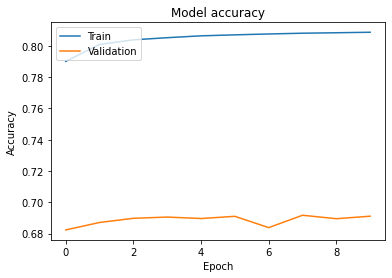

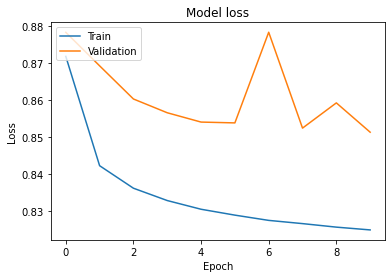

In [32]:


accuracyName = 'accuracyMiddlewindowQ2W19Model2.png'
lossName = 'lossMiddlewindowQ2W19Model2.png'

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig(accuracyName)
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
#plt.savefig(lossName)
plt.show()




In [ ]:
f = gzip.GzipFile('cb513_window19Q8.npy.gz', "r")
X_test_window = np.load(f)

In [ ]:
x_test_final = X_test_window[:,:,(21+classSize):]
#x_test_final = X_test_window[:,:,0:21]
y_test_final = X_test_window[:,:,21: (21+classSize)]
print(x_test_final.shape)
print(y_test_final.shape)

In [ ]:
y_test_final = np.reshape(y_test_final, (80119,19*8))
print(y_test_final.shape)
y_test_final = y_test_final[:,0:8]
print(y_test_final.shape)

In [ ]:
from keras.models import load_model

model = load_model('best.hdf5')

In [ ]:
scores = model.evaluate(x_test_final, y_test_final)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))
print("yes boi")

In [ ]:
fold = 3
m.save('model_' + str(fold) + '.h5')  # creates a HDF5 file 
with open('model_scores_' + str(fold), 'wb') as file_pi:
    pickle.dump(scores, file_pi)
with open('model_history_' + str(fold), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)